In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.cuda.empty_cache()

random_seed = 0
torch.manual_seed(random_seed)

In [2]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 500

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([500, 3, 32, 32])


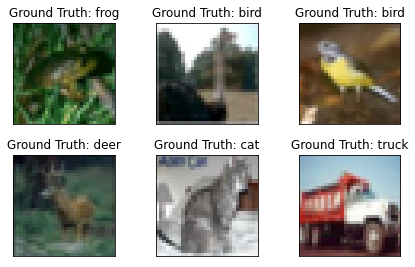

In [4]:
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow((example_data[i]/2+0.5).permute(1,2,0))
    plt.title("Ground Truth: {}".format(classes[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])

In [5]:
# network flowchart:
#input vector --- random initialized weights ---> hyperdimensional vecotor ---> one_hot_net l1 ---> ...ln... ---> sigmoid/softmax output
#One hot net

class One_hot_op(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A, W, epsilon):
        Z = torch.matmul(W, A)
        ctx.Z = Z
        ctx.A = A
        ctx.W = W
        ctx.epsilon = epsilon
        ret = Z > epsilon
        #print(ret[1:10][1:10])
        return ret.float()

    @staticmethod
    def backward(ctx, dL_dA):
        step = ctx.Z > ctx.epsilon
        step = step.float()
        dL_dZ = dL_dA * step 
        
        dZ_dW = torch.transpose(ctx.A, 0,1)
        dZ_dW = torch.sign(dZ_dW)
        dZ_dA = torch.transpose(ctx.W, 0,1)
        dZ_dA = torch.sign(dZ_dA)
        dA = torch.matmul(dZ_dA,dL_dZ)
        dW = torch.matmul(dL_dZ,dZ_dW)
        return dA, dW, None


class One_hot_layer(nn.Module):
    def __init__(self, in_dim, out_dim, initialization_f, epsilon):
        super(One_hot_layer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.epsilon = epsilon
        self.initialization_f = initialization_f
        initialized_weight = initialization_f(out_dim, in_dim)
        self.weight = nn.Parameter(initialized_weight, requires_grad = True)
        self.op = One_hot_op
        
    def __str__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_dim) + ',' \
               + str(self.out_dim) + ')'
        
    def forward(self, A):
        #print(self.weight[:3][:3])
        return self.op.apply(A, self.weight, self.epsilon)
    

class One_hot_net(nn.Module):
    def __init__(self, in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon, n_layers=2, layer_size_factor=[1, 5], dropout=[-1, 0.5]):
        super(One_hot_net, self).__init__()
        self.layers = nn.ModuleList()
        self.in_dim = in_dim
        feature_len = in_dim * encoder_multiplier
        self.feature_len = feature_len
        self.n_layers=n_layers
        self.layer_size_factor=layer_size_factor
        self.dropout=dropout
        self.epsilon = epsilon
        self.n_class = n_class
        self.f_encoder = f_encoder
        self.f_initializer = f_initializer
        for i in range(n_layers):
            if dropout[i] > 0:
                self.layers.append(nn.Dropout(dropout[i]))
            if i < n_layers - 1:
                self.layers.append(
                    One_hot_layer(int(feature_len // layer_size_factor[i]), int(feature_len // layer_size_factor[i + 1]), f_initializer, epsilon))
        self.tail = nn.Linear(int(feature_len // layer_size_factor[-1]), n_class)
    
    def flatten(self, X):
        return X.view(X.shape[0], X.shape[1]*X.shape[2])
    
    def unflatten(self, X):
        return X.view(X.shape[0], int(self.in_dim**(1/2)), int(self.in_dim**(1/2)))

    def forward(self, X):
        X = self.flatten(X)
        X = torch.transpose(X, 0, 1)
        X = self.f_encoder.apply(X)
        for layer in self.layers:
            X = layer(X)
        X = torch.transpose(X, 0, 1)
        X = self.tail(X)
        return self.unflatten(X)

class OHN_3_channels(nn.Module):
    def __init__(self, in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon, n_layers=2, layer_size_factor=[1, 5], dropout=[-1, 0.5]):
        super(OHN_3_channels, self).__init__()
        self.c1 = One_hot_net(in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon, n_layers, layer_size_factor, dropout)
        self.c2 = One_hot_net(in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon, n_layers, layer_size_factor, dropout)
        self.c3 = One_hot_net(in_dim, n_class, f_encoder, encoder_multiplier, f_initializer, epsilon, n_layers, layer_size_factor, dropout)
    def forward(self, X):
        out = torch.empty(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
        
        out[:,0,:,:] = self.c1(X[:,0,:,:])
        out[:,1,:,:] = self.c2(X[:,1,:,:])
        out[:,2,:,:] = self.c3(X[:,2,:,:])
        return out
        

In [6]:
#initializers and encoders
def uniform_initializer(out_dim, in_dim, cuda = True):
    tensor = torch.empty(out_dim, in_dim)
    if cuda:
        return torch.nn.init.uniform_(tensor, a=-2, b=2).cuda()
    else: 
        return torch.nn.init.uniform_(tensor, a=-2, b=2)

class simple_encoder():
    def __init__(self, out_dim, in_dim):
        self.W = uniform_initializer(out_dim, in_dim)
        
    def apply(self, X):
        #print(X.shape)
        #print(self.W.shape)
        return torch.matmul(self.W, X)
    
class simple_encoder_wthreshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.epsilon = epsilon
        
    def apply(self, X):
        #print(X.shape)
        #print(self.W.shape)
        return (torch.matmul(self.W, X) > self.epsilon).float()
    
class simple_encoder_w3threshold():
    def __init__(self, out_dim, in_dim, epsilon, cuda = True):
        self.W = uniform_initializer(out_dim, in_dim, cuda)
        self.epsilon = epsilon
        
    def apply(self, X):
        #print(X.shape)
        #print(self.W.shape)
        vec = torch.matmul(self.W, X)
        ret = (vec > self.epsilon).float() + (-1)* (vec < -self.epsilon).float()
        #print(ret)
        return ret

In [8]:

parameters = {
    'in_dim': 1024,
    'n_class': 1024,
    'f_encoder': simple_encoder_wthreshold(1024*40, 1024, 1e-3),
    'f_initializer': uniform_initializer,
    'encoder_multiplier': 40,
    'epsilon': 10e-3,
    'n_layers': 1,
    'layer_size_factor': [1],
    'dropout': [-1]
}
'''
parameters = {
    'in_dim': 1024,
    'n_class': 1024,
    'f_encoder': simple_encoder_w3threshold(1024*80, 1024, 2),
    'f_initializer': uniform_initializer,
    'encoder_multiplier': 80,
    'epsilon': 10e-3,
    'n_layers': 1,
    'layer_size_factor': [1],
    'dropout': [-1]
}'''

"\nparameters = {\n    'in_dim': 1024,\n    'n_class': 1024,\n    'f_encoder': simple_encoder_w3threshold(1024*80, 1024, 2),\n    'f_initializer': uniform_initializer,\n    'encoder_multiplier': 80,\n    'epsilon': 10e-3,\n    'n_layers': 1,\n    'layer_size_factor': [1],\n    'dropout': [-1]\n}"

In [9]:
device = torch.device("cuda:0")
model1 = OHN_3_channels(parameters['in_dim'], parameters['n_class'], parameters['f_encoder'], parameters['encoder_multiplier'], 
                     parameters['f_initializer'], parameters['epsilon'], parameters['n_layers'], 
                     parameters['layer_size_factor'], parameters['dropout']).to(device)

#model1 = toy_Net().to(device)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.5)
#optimizer1 = torch.optim.SGD([{'params': model1.layers.parameters(), 'lr': 0.01}, {'params': model1.tail.parameters(), 'lr': 0.01}], lr=0.01, momentum=0.5)

In [10]:
from torchsummary import summary
summary(model1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      41,944,064
       One_hot_net-2               [-1, 32, 32]               0
            Linear-3                 [-1, 1024]      41,944,064
       One_hot_net-4               [-1, 32, 32]               0
            Linear-5                 [-1, 1024]      41,944,064
       One_hot_net-6               [-1, 32, 32]               0
Total params: 125,832,192
Trainable params: 125,832,192
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 480.01
Estimated Total Size (MB): 480.07
----------------------------------------------------------------


In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch, model, optimizer, trainloader, log_interval = 10, device = torch.device("cuda:0")):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data).to(device)
        loss = nn.MSELoss()(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(model.state_dict(), '/results/model.pth')
            #torch.save(optimizer.state_dict(), '/results/optimizer.pth')
    return model, optimizer


In [13]:
def test(model, test_loader, device = torch.device("cuda:0")):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data).to(device)
            test_loss += nn.MSELoss()(output, data).item()
    test_loss /= len(test_loader.dataset)
    test_loss *=500
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}\n'.format(
        test_loss))
    return test_loss

In [14]:
model_name = "crypto_cfnet1"
test(model1, test_loader)
for epoch in range(1, n_epochs + 1):
    train(epoch, model1, optimizer1, train_loader)
    test(model1, test_loader)


Test set: Avg. loss: 0.419337

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.442727
Train Epoch: 1 [640/50000 (1%)]	Loss: 0.291862
Train Epoch: 1 [1280/50000 (3%)]	Loss: 0.235006
Train Epoch: 1 [1920/50000 (4%)]	Loss: 0.225927
Train Epoch: 1 [2560/50000 (5%)]	Loss: 0.209222
Train Epoch: 1 [3200/50000 (6%)]	Loss: 0.201420
Train Epoch: 1 [3840/50000 (8%)]	Loss: 0.189464
Train Epoch: 1 [4480/50000 (9%)]	Loss: 0.175281
Train Epoch: 1 [5120/50000 (10%)]	Loss: 0.189072
Train Epoch: 1 [5760/50000 (12%)]	Loss: 0.165390
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.175475
Train Epoch: 1 [7040/50000 (14%)]	Loss: 0.173067
Train Epoch: 1 [7680/50000 (15%)]	Loss: 0.174841
Train Epoch: 1 [8320/50000 (17%)]	Loss: 0.168487
Train Epoch: 1 [8960/50000 (18%)]	Loss: 0.155939
Train Epoch: 1 [9600/50000 (19%)]	Loss: 0.158430
Train Epoch: 1 [10240/50000 (20%)]	Loss: 0.156218
Train Epoch: 1 [10880/50000 (22%)]	Loss: 0.150793
Train Epoch: 1 [11520/50000 (23%)]	Loss: 0.144275
Train Epoch: 1 [12160/50000 (24%)]	Loss: 0.149

Text(0, 0.5, 'MSE loss')

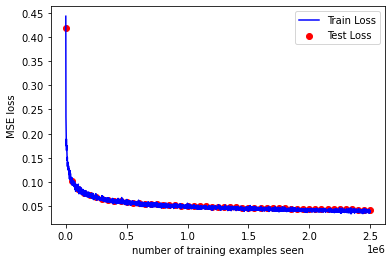

In [15]:
## fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('MSE loss')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


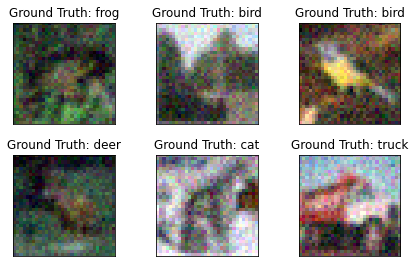

In [16]:
fname = "figures\cryptography\\CIFAR10_reconstructed_80D.png"
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
reconstructed_example_data = model1(example_data.to(torch.device("cuda:0"))).cpu().detach().numpy()
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(reconstructed_example_data[i]/2+0.5, [1,2,0]))
    plt.title("Ground Truth: {}".format(classes[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])
#plt.savefig(fname)

In [17]:
print(reconstructed_example_data.shape)


(500, 3, 32, 32)


In [18]:
def show_img(im):
    plt.imshow(im)
    plt.show()

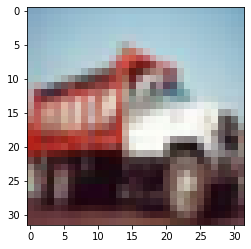

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


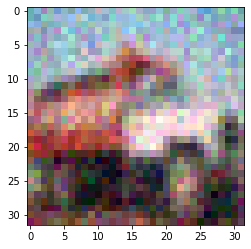

In [19]:
decrypted_images = reconstructed_example_data/2+0.5
original_images = example_data/2+0.5
#print(images.shape)
show_img(np.transpose(original_images[5], [1,2,0]))
show_img(np.transpose(decrypted_images[5], [1,2,0]))

In [68]:
original = np.transpose(original_images[5], [1,2,0])
noisy = np.transpose(decrypted_images[5], [1,2,0])
#print(noisy.tolist() )
noisy[noisy < 0] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


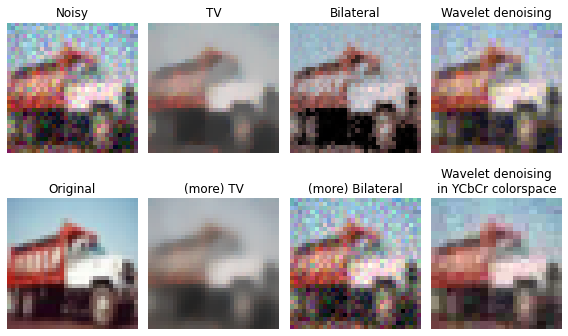

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


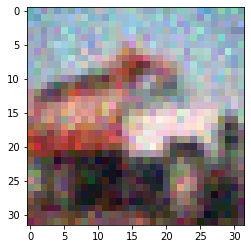

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


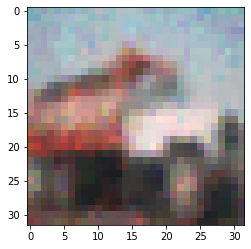

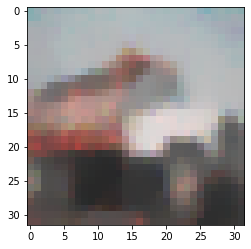

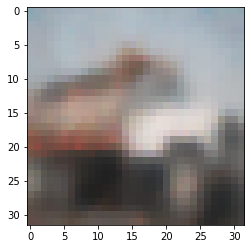

In [69]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
#sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
#print(f'Estimated Gaussian noise standard deviation = {sigma_est}')
multichannel = True

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15, multichannel=multichannel))
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy, rescale_sigma=True))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(denoise_bilateral(noisy, sigma_color=0.01, sigma_spatial=15, multichannel=multichannel))
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(denoise_wavelet(noisy, convert2ycbcr=True,
                                rescale_sigma=True, multichannel=multichannel))
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

for i in range(1,5):
    #for s in range (5):
        plt.imshow(denoise_tv_chambolle(noisy, weight=0.01*i**2))
        plt.show()

#plt.imshow(denoise_bilateral(noisy, sigma_color=0.01, sigma_spatial=15, multichannel=True)/2+denoise_tv_chambolle(noisy, weight=0.1)/2)
#plt.show()

In [20]:
#print(original_images[5,0])

h1,c1 = np.histogram(original_images[5,0], bins=50)
h2,c2 = np.histogram(original_images[5,1], bins=50)
h3,c3 = np.histogram(original_images[5,2], bins=50)
#print(c1)
h = [h1,h2,h3]
c = [c1,c2,c3]
for i in range(len(h)):
    ind = np.argsort(h[i])
    #print(ind[:100])
    c[i] = c[i][ind[:20]]
    
#print(c[i])

In [21]:
def vec_round(values, rounds):
    x = np.subtract.outer(values, rounds)
    y = np.argmin(abs(x), axis=1)
    return rounds[y]

In [22]:
og = original_images[5]
dg = decrypted_images[5]
img = np.zeros([3,32,32])
for i in range(3):
    img[i] = np.reshape(vec_round(dg[i].flatten(), c[i]),[32,32])

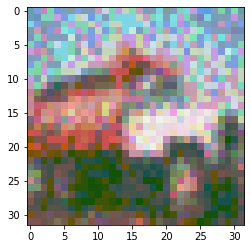

In [23]:
show_img(np.transpose(img, [1,2,0]))